# DL Project 24/25

## Download and unzip test dataset

In [1]:
!gdown 1G7u9RBG_2_vY889Fsb2hMGz_AB8jzJMR
!mkdir dataset
!tar -xvf  'imagenet-a.tar' -C 'dataset'

zsh:1: command not found: gdown
mkdir: impossibile creare la directory "dataset": File già esistente
tar: imagenet-a.tar: funzione "open" non riuscita: File o directory non esistente
tar: Error is not recoverable: exiting now


## Import necessary libraries

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from pkg_resources import packaging
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Union, List,Tuple
from utils.tools import Summary, AverageMeter, ProgressMeter, accuracy, load_model_weight, set_random_seed
import time
from data.datautils import AugMixAugmenter, build_dataset
from copy import deepcopy
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

/home/emmavico/Programmi/Università/deep-learning-unitn/utils/tools.py:122: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if device is not 'cpu':


## Parameters

In [3]:
DEVICE = "cuda:0"

# Defaults -----------------
n_ctx = 4
ctx_init = None
learned_cls = False
lr = 5e-3
resolution = 244
batch_size = 64
test_sets = 'A/R/V/K/I'
tpt = True
data = "DIR"
dataset_mode = "test"
workers = 4
# -------------------------

## Dataset Loader

In [4]:
class DatasetImageNetA(Dataset):
    def __init__(self, dataset_path, transform=None, target_transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.target_transform = target_transform

        # Read the mapping file
        with open(os.path.join(dataset_path ,"README.txt"), "r") as f:
            lines = f.readlines()[12:] #skips first 12 lines

        # Create the mapping dictionary
        self.mapping = {}
        for line in lines:
            split_line = line.split()
            if len(split_line) > 1:
                numeric_id = split_line[0][1:]
                name = " ".join(split_line[1:]).strip()
                self.mapping[int(numeric_id)] = name.lower()

        # Create the labels list
        labels = []
        for cl in self.mapping.keys():
            for file_name in os.listdir(os.path.join(dataset_path, f"n{str(cl).zfill(8)}")):
                labels.append((cl, file_name))
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, f"n{str(self.labels[idx][0]).zfill(8)}", self.labels[idx][1])
        image = read_image(img_path)
        label = self.labels[idx][0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
val_data = DatasetImageNetA(os.path.join("dataset", "imagenet-a"))
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([1, 3, 411, 800])
Labels batch shape: torch.Size([1])


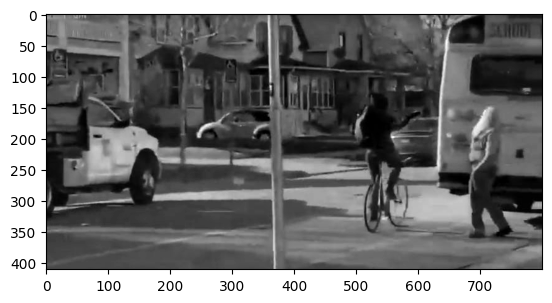

Label: 4146614
school bus


In [6]:
# Quick test to check if dataset loader works correctly
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0].numpy()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(val_data.mapping[int(label)])

## Load the model

In [7]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Create the prompts

In [8]:
prompts = []
for key in val_data.mapping:
    prompts.append("a photo of a " + val_data.mapping[key])
print(prompts)

['a photo of a stingray', 'a photo of a goldfinch', 'a photo of a junco', 'a photo of a american robin', 'a photo of a jay', 'a photo of a bald eagle', 'a photo of a vulture', 'a photo of a newt', 'a photo of a american bullfrog', 'a photo of a box turtle', 'a photo of a green iguana', 'a photo of a agama', 'a photo of a chameleon', 'a photo of a american alligator', 'a photo of a garter snake', 'a photo of a harvestman', 'a photo of a scorpion', 'a photo of a tarantula', 'a photo of a centipede', 'a photo of a sulphur-crested cockatoo', 'a photo of a lorikeet', 'a photo of a hummingbird', 'a photo of a toucan', 'a photo of a duck', 'a photo of a goose', 'a photo of a koala', 'a photo of a jellyfish', 'a photo of a sea anemone', 'a photo of a flatworm', 'a photo of a snail', 'a photo of a crayfish', 'a photo of a hermit crab', 'a photo of a flamingo', 'a photo of a great egret', 'a photo of a oystercatcher', 'a photo of a pelican', 'a photo of a sea lion', 'a photo of a chihuahua', 'a 

## Predict label

In [9]:
img = train_features[0]

inputs = processor(text=prompts, images=img, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

predicted_label_index = torch.argmax(probs, dim=1)

# Get the predicted label based on the index
predicted_label = prompts[predicted_label_index]

# Print the predicted label and its probability
predicted_probability = probs[0][predicted_label_index].item()

print(f"Predicted label: {predicted_label}")
print(f"Probability: {predicted_probability:.4f}")

Predicted label: a photo of a unicycle
Probability: 0.9485


In [10]:
model.to(DEVICE)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [11]:
#changed some symble to adapt to our version of CLIP
class TextEncoder(nn.Module):
    def __init__(self,clip_model):
        super().__init__()
        self.transformer = clip_model.text_model
        self.positional_embedding = clip_model.text_model.embeddings.position_embedding
        self.ln_final = clip_model.text_model.final_layer_norm
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
    
    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [12]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class Tokenizer(object):
    def __init__(self, clip_processor):
        self.clip_tokenizer = clip_processor.tokenizer
        self.pat = re.compile(
            r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)
# TODO: verificare se si pèuò utilizzare direttamente il tokenizer decode

    def tokenize(self, texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> torch.LongTensor:
        """
        Returns the tokenized representation of given input string(s)

        Parameters
        ----------
        texts : Union[str, List[str]]
            An input string or a list of input strings to tokenize

        context_length : int
            The context length to use; all CLIP models use 77 as the context length

        truncate: bool
            Whether to truncate the text in case its encoding is longer than the context length

        Returns
        -------
        A two-dimensional tensor containing the resulting tokens, shape = [number of input strings, context_length]
        """
        if isinstance(texts, str):
            texts = [texts]

        sot_token = self.clip_tokenizer.vocab["<|startoftext|>"]
        eot_token = self.clip_tokenizer.vocab["<|endoftext|>"]
        all_tokens = [[sot_token] +
                      self.clip_tokenizer.encode(text) + [eot_token] for text in texts]
        result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

        for i, tokens in enumerate(all_tokens):
            if len(tokens) > context_length:
                if truncate:
                    tokens = tokens[:context_length]
                    tokens[-1] = eot_token
                else:
                    raise RuntimeError(
                        f"Input {texts[i]} is too long for context length {context_length}")
            result[i, :len(tokens)] = torch.tensor(tokens)

        return result

    def encode(self, text):
        return self.clip_tokenizer.encode(text)

    def decode(self, tokens):
        return self.clip_tokenizer.decode(tokens)

In [13]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, clip_processor, classnames, batch_size=None, n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = DEVICE
        #TODO ctx_dim = clip_model.ln_final.weight.shape[0] Adapt it to our CLIP
        ctx_dim = 768
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size
        self.tokenizer = Tokenizer(clip_processor)

        # self.ctx, prompt_prefix = self.reset_prompt(ctx_dim, ctx_init, clip_model)

        if ctx_init:
            # use given words to initialize context vectors
            print(
                "Initializing the contect with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            if '[CLS]' in ctx_init:
                ctx_list = ctx_init.split(" ")
                split_idx = ctx_list.index("[CLS]")
                ctx_init = ctx_init.replace("[CLS] ", "")
                ctx_position = "middle"
            else:
                split_idx = None
            self.split_idx = split_idx
            n_ctx = len(ctx_init.split(" "))
            prompt = self.tokenizer.tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.text_model.position_embedding(
                    prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            print("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        self.prompt_prefix = prompt_prefix

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None:
            ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  # (N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors)  # to be optimized

        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(self.tokenizer.encode(name))
                         for name in classnames]
            prompts = [prompt_prefix + " " + name + "." for name in classnames]
        else:
            print("Random initialization: initializing a learnable class token")
            # assume each learnable cls_token is only 1 word
            cls_vectors = torch.empty(n_cls, 1, ctx_dim, dtype=dtype)
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [prompt_prefix + " " +
                       cls_token + "." for _ in classnames]

            self.cls_init_state = cls_vectors.detach().clone()
            self.cls = nn.Parameter(cls_vectors)  # to be optimized

        tokenized_prompts = torch.cat([self.tokenizer.tokenize(p)
                                      for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.text_model.embeddings.token_embedding(
                tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        if self.learned_cls:
            self.register_buffer(
                "token_suffix", embedding[:, 1 + n_ctx + 1:, :])  # ..., EOS
        else:
            self.register_buffer(
                "token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames
        self.clip_model = clip_model

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None:
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)

        if self.learned_cls:
            assert self.class_token_position == "end"
        if self.class_token_position == "end":
            if self.learned_cls:
                cls = self.cls
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        cls,     # (n_cls, 1, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
            else:
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
        elif self.class_token_position == "middle":
            # TODO: to work with a batch of prompts
            if self.split_idx is not None:
                # split the ctx at the position of [CLS] in `ctx_init`
                half_n_ctx = self.split_idx
            else:
                half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i_half1 = ctx[i: i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i: i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i = ctx[i: i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts
    
    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors) # to be optimized
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)
    
    def reset_classnames(self, classnames):
        self.n_cls = len(classnames)
        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(self.tokenizer.encode(name)) for name in classnames]
            prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        else:
            cls_vectors = torch.empty(self.n_cls, 1, self.ctx_dim, dtype=self.dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [self.prompt_prefix + " " + cls_token + "." for _ in classnames]
            # TODO: re-init the cls parameters
            # self.cls = nn.Parameter(cls_vectors) # to be optimized
            self.cls_init_state = cls_vectors.detach().clone()
        tokenized_prompts = torch.cat([self.tokenize(p) for p in prompts]).to(self.device)


        with torch.no_grad():
            embedding = self.clip_model.text_model.token_embedding(
                tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

In [14]:
class ClipTestTimeTuning(nn.Module):
    def __init__(self, clip_model, clip_processor, classnames, batch_size,  criterion='cosine',
                 n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super(ClipTestTimeTuning, self).__init__()
        self.image_encoder = clip_model.vision_model
        self.text_encoder = TextEncoder(clip_model)
        # clip_model.logit_scale.data
        self.logit_scale = clip_processor.image_processor.rescale_factor
        # prompt tuning
        self.prompt_learner = PromptLearner(
            clip_model,clip_processor, classnames, batch_size, n_ctx, ctx_init, ctx_position, learned_cls)
        self.criterion = criterion

    @property
    def dtype(self):
        return self.image_encoder.conv1.weight.dtype

    # restore the initial state of the prompt_learner (tunable prompt)
    def reset(self):
        self.prompt_learner.reset()

    def reset_classnames(self, classnames, arch):
        self.prompt_learner.reset_classnames(classnames)

    def get_text_features(self):
        text_features = []
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        t_features = self.text_encoder(prompts, tokenized_prompts)
        text_features.append(
            t_features / t_features.norm(dim=-1, keepdim=True))
        text_features = torch.stack(text_features, dim=0)

        return torch.mean(text_features, dim=0)

    def inference(self, image):
        with torch.no_grad():
            image_features = self.image_encoder(image.type(self.dtype))

        text_features = self.get_text_features()
        image_features = image_features / \
            image_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def forward(self, input):
        if isinstance(input, Tuple):
            view_0, view_1, view_2 = input
            return self.contrast_prompt_tuning(view_0, view_1, view_2)
        elif len(input.size()) == 2:
            return self.directional_prompt_tuning(input)
        else:
            return self.inference(input)

In [15]:
classnames_all = []
for key in val_data.mapping:
    classnames_all.append(val_data.mapping[key])
classnames_all

['stingray',
 'goldfinch',
 'junco',
 'american robin',
 'jay',
 'bald eagle',
 'vulture',
 'newt',
 'american bullfrog',
 'box turtle',
 'green iguana',
 'agama',
 'chameleon',
 'american alligator',
 'garter snake',
 'harvestman',
 'scorpion',
 'tarantula',
 'centipede',
 'sulphur-crested cockatoo',
 'lorikeet',
 'hummingbird',
 'toucan',
 'duck',
 'goose',
 'koala',
 'jellyfish',
 'sea anemone',
 'flatworm',
 'snail',
 'crayfish',
 'hermit crab',
 'flamingo',
 'great egret',
 'oystercatcher',
 'pelican',
 'sea lion',
 'chihuahua',
 'golden retriever',
 'rottweiler',
 'german shepherd dog',
 'pug',
 'red fox',
 'persian cat',
 'lynx',
 'lion',
 'american black bear',
 'mongoose',
 'ladybug',
 'rhinoceros beetle',
 'weevil',
 'fly',
 'bee',
 'ant',
 'grasshopper',
 'stick insect',
 'cockroach',
 'mantis',
 'leafhopper',
 'dragonfly',
 'monarch butterfly',
 'small white',
 'gossamer-winged butterfly',
 'starfish',
 'cottontail rabbit',
 'porcupine',
 'fox squirrel',
 'marmot',
 'bison'

In [16]:


model = ClipTestTimeTuning(model, processor, classnames, None,
                           n_ctx=n_ctx, ctx_init=ctx_init, learned_cls=learned_cls)

Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4


In [17]:
def select_confident_samples(logits, top):
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[
        :int(batch_entropy.size()[0] * top)]
    return logits[idx], idx

In [18]:
def avg_entropy(outputs):
    # logits = outputs.log_softmax(dim=1) [N, 1000]
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    # avg_logits = logits.mean(0) [1, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

In [19]:
def test_time_tuning(model, inputs, optimizer, scaler, args):
    selected_idx = None
    for j in range(args.tta_steps):
        with torch.cuda.amp.autocast():
            utput = model(inputs)

            if selected_idx is not None:
                output = output[selected_idx]
            else:
                output, selected_idx = select_confident_samples(
                    output, args.selection_p)

            loss = avg_entropy(output)

        optimizer.zero_grad()
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.step(optimizer)
        scaler.update()
    return

In [20]:
def test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler, args):
    #model_state is not used
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)

    progress = ProgressMeter(
        len(val_loader),
        [batch_time, top1, top5],
        prefix='Test: ')

    # reset model and switch to evaluate mode
    model.eval()
    #if not args.cocoop:  # no need to reset cocoop because it's fixed
    with torch.no_grad():
        model.reset()
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(DEVICE, non_blocking=True)
            image = images[0]
        else:
            if len(images.size()) > 4:
                # when using ImageNet Sampler as the dataset
                assert images.size()[0] == 1
                images = images.squeeze(0)
            images = images.cuda(DEVICE, non_blocking=True)
            image = images
        target = target.cuda(DEVICE, non_blocking=True)
        if tpt:
            images = torch.cat(images, dim=0)

        # reset the tunable prompt to its initial state
        if args.tta_steps > 0:
            with torch.no_grad():
                model.reset()
        optimizer.load_state_dict(optim_state)
        test_time_tuning(model, images, optimizer, scaler, args)
    


        with torch.no_grad():
            with torch.cuda.amp.autocast():
                output = model(image)
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        top1.update(acc1[0], image.size(0))
        top5.update(acc5[0], image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args.print_freq == 0:
            progress.display(i)

    progress.display_summary()

    return [top1.avg, top5.avg]

In [21]:



set_random_seed(42)
print("Use GPU: {} for training".format(DEVICE))

# create model (zero-shot clip model (ViT-L/14@px336) with promptruning)
"""     if args.test_sets in fewshot_datasets:
    classnames = eval("{}_classes".format(args.test_sets.lower())) """

""" if args.load is not None:
    print("Use pre-trained soft prompt (CoOp) as initialization")
    pretrained_ctx = torch.load(args.load)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == args.n_ctx
    with torch.no_grad():
        model.prompt_learner[0].ctx.copy_(pretrained_ctx)
        model.prompt_learner[0].ctx_init_state = pretrained_ctx
model_state = None """

for name, param in model.named_parameters():
    if "text_encoder" not in name:
        param.requires_grad_(False)

#print("=> Model created: visual backbone {}".format(args.arch))

""" if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    assert args.gpu is not None
    torch.cuda.set_device(args.gpu)
    model = model.cuda(args.gpu) """

# define optimizer
""" if args.cocoop:
    optimizer = None
    optim_state = None
else: """
trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, lr)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

# norm stats from clip.load()
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                    std=[0.26862954, 0.26130258, 0.27577711])

# iterating through eval datasets
datasets = test_sets.split("/")
results = {}
for set_id in datasets:
    if tpt:
        base_transform = transforms.Compose([
            transforms.Resize(resolution, interpolation=BICUBIC),
            transforms.CenterCrop(resolution)])
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            normalize])
        data_transform = AugMixAugmenter(base_transform, preprocess, n_views=batch_size-1,
                                            augmix=len(set_id) > 1)
        batchsize = 1
    else:
        data_transform = transforms.Compose([
            transforms.Resize(resolution, interpolation=BICUBIC),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            normalize,
        ])
        batchsize = batch_size

    print("evaluating: {}".format(set_id))
    # reset the model
    # Reset classnames of custom CLIP model
    if len(set_id) > 1:
        # fine-grained classification datasets
        classnames = eval("{}_classes".format(set_id.lower()))
    else:
        assert set_id in ['A', 'R', 'K', 'V', 'I']
        classnames = []
        if set_id in ['A', 'R', 'V']:
            label_mask = eval("imagenet_{}_mask".format(set_id.lower()))
            if set_id == 'R':
                for i, m in enumerate(label_mask):
                    if m:
                        classnames.append(classnames_all[i])
            else:
                classnames = [classnames_all[i] for i in label_mask]
        else:
            classnames = classnames_all
    """ if args.cocoop:
        model.prompt_generator.reset_classnames(classnames, args.arch)
        model = model.cpu()
        model_state = model.state_dict()
        model = model.cuda(args.gpu)
    else: """
    model.reset_classnames(classnames)

    val_dataset = build_dataset(
        set_id, data_transform, data, mode=dataset_mode)
    print("number of test samples: {}".format(len(val_dataset)))
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batchsize, shuffle=True,
        num_workers=workers, pin_memory=True)

    results[set_id] = test_time_adapt_eval(
        val_loader, model, optimizer, optim_state, scaler, args)
    del val_dataset, val_loader
    try:
        print("=> Acc. on testset [{}]: @1 {}/ @5 {}".format(
            set_id, results[set_id][0], results[set_id][1]))
    except:
        print("=> Acc. on testset [{}]: {}".format(
            set_id, results[set_id]))

print("======== Result Summary ========")
print("params: nstep	lr	bs")
print("params: {}	{}	{}".format(args.tta_steps, args.lr, args.batch_size))
print("\t\t [set_id] \t\t Top-1 acc. \t\t Top-5 acc.")
for id in results.keys():
    print("{}".format(id), end="	")
print("\n")
for id in results.keys():
    print("{:.2f}".format(results[id][0]), end="	")
print("\n")